Python version should be `3.11`.

Scikit-learn version should be `1.5.2`.

In [1]:
import sklearn
import platform

print(f"Python version is {platform.python_version()}")
print(f"Scikit-learn version is {sklearn.__version__}")

Python version is 3.11.9
Scikit-learn version is 1.5.2


## Import data

In [2]:
import pandas as pd
df1 = pd.read_parquet("validated_data/cleaned1.parquet")
df2 = pd.read_parquet("validated_data/cleaned2.parquet")
df3 = pd.read_parquet("validated_data/cleaned3.parquet")

dfs = [df1, df2, df3]
for i, df in enumerate(dfs):
    dfs[i] = df[df["Faulty"] == False]
    print(f"Building {i+1} has {len(dfs[i])} out of {len(df)} valid rows.")
df1, df2, df3 = dfs

Building 1 has 376821 out of 2097150 valid rows.
Building 2 has 22716 out of 520938 valid rows.
Building 3 has 467517 out of 1942515 valid rows.


## Data preparation

In [3]:
#df2.groupby("Zone_name").count()

Only keep columns with useful information.
- `Slab_temp` and `Dew_temp` values do not vary in building 1
- `building_no` is the same value within dataframes
- `Fan_on_group` and `Cumulative_fan_on_mins` values were calculated using the target variable `Fan_status`
- `Date` and `Time` cannot be easily converted to numeric values
- `Year` values should probably not be used for prediction
- `Damper_open_group` and `Louver_open_group` are categorical labels
- Cumulative metrics probably won't be available when trying to predict future values
- `Louver_status` values are missing in building 3

In [4]:
exclude = ["building_no", "Fan_on_group", "Date", "Time", "Year", "Damper_open_group", "Louver_open_group", "Faulty", "Cumulative_fan_on_mins", "Cumulative_damper_open_mins", "Cumulative_louver_open_mins"]
exclude_df1 = exclude + ["Slab_temp", "Dew_temp", "Slab_temp_diff", "Dew_temp_diff"]
exclude_df3 = exclude + ["Louver_status"]

df1 = df1[df1.columns.difference(exclude_df1)]
df2 = df2[df2.columns.difference(exclude)]
df3 = df3[df3.columns.difference(exclude_df3)]
dfs = [df1, df2, df3]

Use `Datetime` to get day of year and minutes past midnight

In [5]:
for df in dfs:
    df["Day_of_Year"] = df["Datetime"].dt.day_of_year
    df["Minutes_past_midnight"] = ((df["Datetime"] - df["Datetime"].dt.normalize()) / pd.Timedelta(minutes=1))
    #df["DOW"] = df["Datetime"].dt.day_name().astype("category")
    del df["Datetime"]

#import seaborn as sns
#sns.heatmap(df1[df1.columns.difference(["Fan_status", "Zone_name", "DOW"])].corr(), cmap="BrBG", vmin=-1, vmax=1)

Remove rows with `NA` values for columns that do not have many `NA` values.

In [6]:
for df in dfs:
    # limit to columns with less than 5% NA values
    cutoff = len(df) // 20

    sums = df.isna().sum()
    sums = sums[sums != 0]
    #print(cutoff)
    #print(sums)
    sums = sums[sums <= cutoff]
    df.dropna(subset=sums.index, inplace=True)

We need to transform `Zone_name` from categorical to numeric. We'll use scikit-learn preprocessing for encoding.

In [7]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import TargetEncoder

def encode(categorical_columns: list[int] | list[int]):
    return make_column_transformer((TargetEncoder(random_state=42), categorical_columns), remainder="passthrough")

#categorical_columns = ["Zone_name"]
#categorical_columns = ["Zone_name", "DOW"]
#df1 = pd.get_dummies(df1, columns=categorical_columns)
#dfs[0] = df1
#df2 = pd.get_dummies(df2, columns=categorical_columns)
#dfs[1] = df2
#df3 = pd.get_dummies(df3, columns=categorical_columns)
#dfs[2] = df3

Dump the processed datasets.

In [8]:
from pathlib import Path

save_folder = Path("output/data")
save_folder.mkdir(parents=True, exist_ok=True)
for i, df in enumerate(dfs):
    df.to_parquet(save_folder / f"building{i+1}.parquet")

## Split datasets into training and testing subsets
We use a 80% training, 10% validation, 10% testing split.

In [9]:
from sklearn.model_selection import train_test_split

train1, test1 = train_test_split(df1, test_size=0.2, random_state=42)
val1, test1 = train_test_split(test1, test_size=0.5, random_state=42)
train2, test2 = train_test_split(df2, test_size=0.2, random_state=42)
val2, test2 = train_test_split(test2, test_size=0.5, random_state=42)
train3, test3 = train_test_split(df3, test_size=0.2, random_state=42)
val3, test3 = train_test_split(test3, test_size=0.5, random_state=42)

Use random undersampling to handle unbalanced training sets.

In [10]:
target = "Fan_status"

for train in [train1, train2, train3]:
    counts = train[target].value_counts()
    if counts["On"] > counts["Off"] * 3:
        # data is already in random order, so we can just remove the relevant records after the cutoff
        drop = train[train[target] == "On"].index[counts["Off"] * 3:]
        train.drop(drop, inplace=True)
    elif counts["Off"] > counts["On"] * 3:
        drop = train[train[target] == "Off"].index[counts["On"] * 3:]
        train.drop(drop, inplace=True)

In [11]:
features1 = df1.columns.to_list()
features1.remove(target)
y_train1 = train1[target]
y_val1 = val1[target]
y_test1 = test1[target]
x_train1 = train1[features1]
x_val1 = val1[features1]
x_test1 = test1[features1]

features2 = df2.columns.to_list()
features2.remove(target)
y_train2 = train2[target]
y_val2 = val2[target]
y_test2 = test2[target]
x_train2 = train2[features2]
x_val2 = val2[features2]
x_test2 = test2[features2]

features3 = df3.columns.to_list()
features3.remove(target)
y_train3 = train3[target]
y_val3 = val3[target]
y_test3 = test3[target]
x_train3 = train3[features3]
x_val3 = val3[features3]
x_test3 = test3[features3]

## Saving and loading models

In [12]:
from sklearn.base import BaseEstimator
from joblib import dump, load

def save_model(model: BaseEstimator, filename: str):
    models_folder = Path("output/models")
    models_folder.mkdir(parents=True, exist_ok=True)
    filename = filename + ".joblib"
    dump(model, models_folder / filename)

def load_model(filename: str) -> BaseEstimator | None:
    models_folder = Path("output/models")
    filename = filename + ".joblib"
    filename: Path = models_folder / filename
    if filename.is_file():
        #print("File found!")
        return load(filename)
    #print("File does not exist!")

## Evaluating Model Performance

In [13]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, roc_auc_score, average_precision_score, matthews_corrcoef, confusion_matrix

def calculate_metrics(model: BaseEstimator, X: pd.Series, y: pd.Series, print_report = True):
    y_predict = model.predict(X)
    # SVM predictions take a long time to compute and are unreliable (https://stackoverflow.com/questions/15111408/how-does-sklearn-svm-svcs-function-predict-proba-work-internally)
    #y_proba = model.predict_proba(X)[:,1]

    if print_report:
        print(classification_report(y, y_predict, digits=4))
    
    tn, fp, fn, tp = confusion_matrix(y, y_predict).ravel()

    return {
        "Accuracy": accuracy_score(y, y_predict),
        "f1": f1_score(y, y_predict, pos_label="On"),
        #"ROC AUC": roc_auc_score(y, y_proba),
        #"PR AUC": average_precision_score(y, y_proba, pos_label="On"),
        "Matthews": matthews_corrcoef(y, y_predict),
        "TN": tn,
        "FP": fp,
        "FN": fn,
        "TP": tp,
    }

model_metrics = {f"Building {n+1}": {} for n in range(3)}
tuned_metrics = {f"Building {n+1}": {} for n in range(3)}

## Decision Tree

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline

tree = DecisionTreeClassifier(random_state=42)
tree = make_pipeline(encode(["Zone_name"]), tree)
model_name = "Decision Tree"

### Building 1

In [15]:
tree.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(tree, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(tree, x_test1, y_test1, print_report=False)
save_model(tree, "decisiontree_building1")

              precision    recall  f1-score   support

         Off     0.9996    0.9998    0.9997     26636
          On     0.9996    0.9989    0.9993     10439

    accuracy                         0.9996     37075
   macro avg     0.9996    0.9994    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



### Building 2

In [16]:
tree.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(tree, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(tree, x_test2, y_test2, print_report=False)
save_model(tree, "decisiontree_building2")

              precision    recall  f1-score   support

         Off     0.9966    0.9471    0.9712      2173
          On     0.4417    0.9286    0.5987        98

    accuracy                         0.9463      2271
   macro avg     0.7192    0.9378    0.7849      2271
weighted avg     0.9727    0.9463    0.9551      2271



### Building 3

In [17]:
tree.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(tree, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(tree, x_test3, y_test3, print_report=False)
save_model(tree, "decisiontree_building3")

              precision    recall  f1-score   support

         Off     0.9998    0.9955    0.9976     45760
          On     0.8263    0.9898    0.9007       985

    accuracy                         0.9954     46745
   macro avg     0.9130    0.9927    0.9492     46745
weighted avg     0.9961    0.9954    0.9956     46745



## Random Forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

model_name = "Random Forest"
forest = RandomForestClassifier(random_state=42, n_jobs=-1)
forest = make_pipeline(encode(["Zone_name"]), forest)

### Building 1

<Axes: >

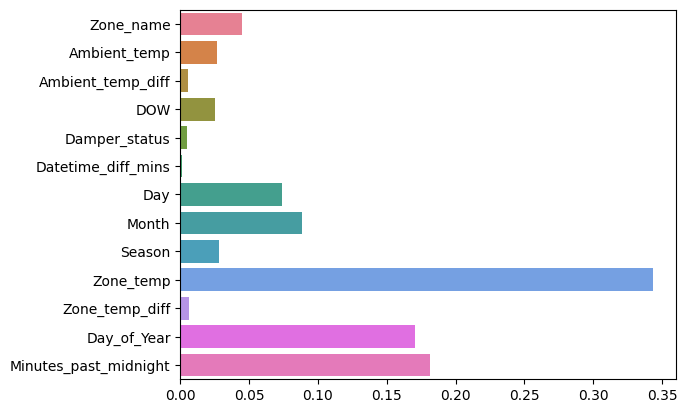

In [19]:
forest.fit(x_train1, y_train1)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [20]:
model_metrics["Building 1"][model_name] = calculate_metrics(forest, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(forest, x_test1, y_test1, print_report=False)
save_model(forest, "randomforest_building1")

              precision    recall  f1-score   support

         Off     0.9994    1.0000    0.9997     26636
          On     0.9999    0.9986    0.9992     10439

    accuracy                         0.9996     37075
   macro avg     0.9997    0.9993    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



### Building 2

<Axes: >

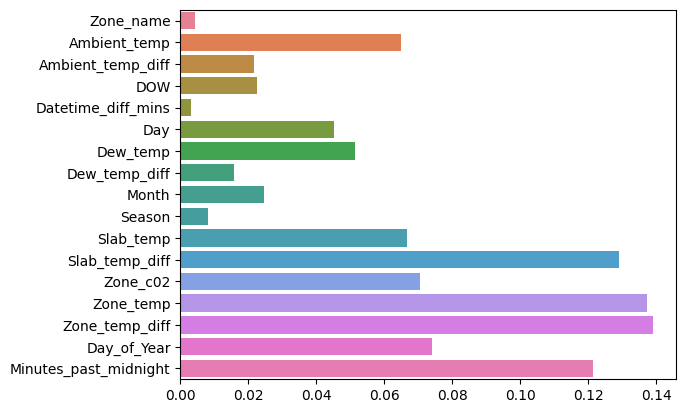

In [21]:
forest.fit(x_train2, y_train2)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [22]:
model_metrics["Building 2"][model_name] = calculate_metrics(forest, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(forest, x_test2, y_test2, print_report=False)
save_model(forest, "randomforest_building2")

              precision    recall  f1-score   support

         Off     0.9963    0.9807    0.9884      2173
          On     0.6818    0.9184    0.7826        98

    accuracy                         0.9780      2271
   macro avg     0.8390    0.9495    0.8855      2271
weighted avg     0.9827    0.9780    0.9795      2271



### Building 3

<Axes: >

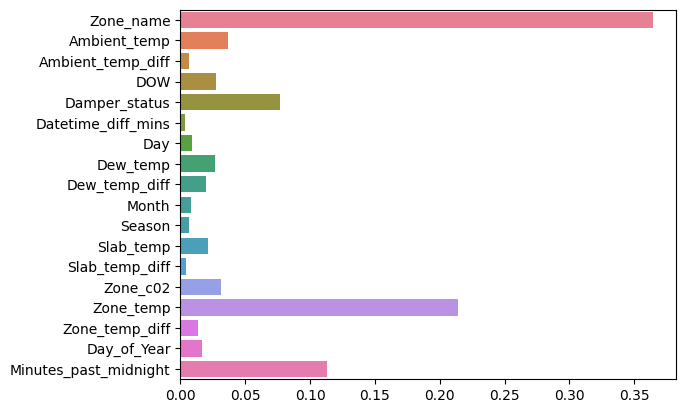

In [23]:
forest.fit(x_train3, y_train3)
feature_names = forest[0].get_feature_names_out()
feature_names = [feature.split("__")[1] for feature in feature_names]
sns.barplot(pd.DataFrame(forest[-1].feature_importances_, index=feature_names).T, orient="h")

In [24]:
model_metrics["Building 3"][model_name] = calculate_metrics(forest, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(forest, x_test3, y_test3, print_report=False)
save_model(forest, "randomforest_building3")

              precision    recall  f1-score   support

         Off     0.9999    0.9960    0.9980     45760
          On     0.8442    0.9959    0.9138       985

    accuracy                         0.9960     46745
   macro avg     0.9221    0.9960    0.9559     46745
weighted avg     0.9966    0.9960    0.9962     46745



## Histogram-based Gradient Boosting

In [25]:
from sklearn.ensemble import HistGradientBoostingClassifier

model_name = "Hist Gradient Boosting"
histgb = HistGradientBoostingClassifier(random_state=42, categorical_features=["Zone_name"])

In [26]:
histgb.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(histgb, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(histgb, x_test1, y_test1, print_report=False)
save_model(histgb, "histgb_building1")

              precision    recall  f1-score   support

         Off     0.9997    0.9998    0.9997     26636
          On     0.9995    0.9991    0.9993     10439

    accuracy                         0.9996     37075
   macro avg     0.9996    0.9995    0.9995     37075
weighted avg     0.9996    0.9996    0.9996     37075



In [27]:
histgb.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(histgb, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(histgb, x_test2, y_test2, print_report=False)
save_model(histgb, "histgb_building2")

              precision    recall  f1-score   support

         Off     0.9977    0.9775    0.9874      2173
          On     0.6549    0.9490    0.7750        98

    accuracy                         0.9762      2271
   macro avg     0.8263    0.9632    0.8812      2271
weighted avg     0.9829    0.9762    0.9783      2271



In [28]:
histgb.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(histgb, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(histgb, x_test3, y_test3, print_report=False)
save_model(histgb, "histgb_building3")

              precision    recall  f1-score   support

         Off     1.0000    0.9966    0.9983     45760
          On     0.8639    0.9990    0.9266       985

    accuracy                         0.9967     46745
   macro avg     0.9319    0.9978    0.9624     46745
weighted avg     0.9971    0.9967    0.9968     46745



## Logistic Regression

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

model_name = "Logistic Regression"
logit = LogisticRegression(random_state=42)
logit = make_pipeline(encode(["Zone_name"]), SimpleImputer(), StandardScaler(), logit)

In [30]:
logit.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(logit, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(logit, x_test1, y_test1, print_report=False)
save_model(logit, "logit_building1")

              precision    recall  f1-score   support

         Off     0.8199    0.8899    0.8535     26636
          On     0.6409    0.5014    0.5626     10439

    accuracy                         0.7805     37075
   macro avg     0.7304    0.6956    0.7080     37075
weighted avg     0.7695    0.7805    0.7716     37075



In [31]:
logit.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(logit, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(logit, x_test2, y_test2, print_report=False)
save_model(logit, "logit_building2")

              precision    recall  f1-score   support

         Off     0.9779    0.9374    0.9572      2173
          On     0.2766    0.5306    0.3636        98

    accuracy                         0.9199      2271
   macro avg     0.6273    0.7340    0.6604      2271
weighted avg     0.9477    0.9199    0.9316      2271



In [32]:
logit.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(logit, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(logit, x_test3, y_test3, print_report=False)
save_model(logit, "logit_building3")

              precision    recall  f1-score   support

         Off     0.9944    0.9661    0.9801     45760
          On     0.3226    0.7492    0.4510       985

    accuracy                         0.9616     46745
   macro avg     0.6585    0.8577    0.7155     46745
weighted avg     0.9803    0.9616    0.9689     46745



## Linear Discriminant Analysis

In [33]:
from sklearn.impute import SimpleImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

model_name = "Linear Discriminant Analysis"
lda = LinearDiscriminantAnalysis()
lda = make_pipeline(encode(["Zone_name"]), SimpleImputer(), lda)

In [34]:
lda.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(lda, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(lda, x_test1, y_test1, print_report=False)
save_model(lda, "lda_building1")

              precision    recall  f1-score   support

         Off     0.8594    0.8939    0.8763     26636
          On     0.6984    0.6270    0.6608     10439

    accuracy                         0.8187     37075
   macro avg     0.7789    0.7604    0.7686     37075
weighted avg     0.8141    0.8187    0.8156     37075



In [35]:
lda.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(lda, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(lda, x_test2, y_test2, print_report=False)
save_model(lda, "lda_building2")

              precision    recall  f1-score   support

         Off     0.9739    0.9457    0.9596      2173
          On     0.2671    0.4388    0.3320        98

    accuracy                         0.9238      2271
   macro avg     0.6205    0.6922    0.6458      2271
weighted avg     0.9434    0.9238    0.9325      2271



In [36]:
lda.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(lda, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(lda, x_test3, y_test3, print_report=False)
save_model(lda, "lda_building3")

              precision    recall  f1-score   support

         Off     0.9931    0.9794    0.9862     45760
          On     0.4174    0.6853    0.5188       985

    accuracy                         0.9732     46745
   macro avg     0.7053    0.8323    0.7525     46745
weighted avg     0.9810    0.9732    0.9764     46745



## Linear Support Vector Machine (SVM)

In [37]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.svm import LinearSVC

model_name = "Linear SVM"
svm = LinearSVC(random_state=42)
svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), svm)

In [38]:
svm.fit(x_train1, y_train1)
model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)
save_model(svm, "svm_linear_building1")

              precision    recall  f1-score   support

         Off     0.8715    0.8749    0.8732     26636
          On     0.6775    0.6708    0.6741     10439

    accuracy                         0.8174     37075
   macro avg     0.7745    0.7728    0.7736     37075
weighted avg     0.8169    0.8174    0.8171     37075



In [39]:
svm.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(svm, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(svm, x_test2, y_test2, print_report=False)
save_model(svm, "svm_linear_building2")

              precision    recall  f1-score   support

         Off     0.9714    0.9540    0.9626      2173
          On     0.2701    0.3776    0.3149        98

    accuracy                         0.9291      2271
   macro avg     0.6207    0.6658    0.6388      2271
weighted avg     0.9412    0.9291    0.9347      2271



In [40]:
svm.fit(x_train3, y_train3)
model_metrics["Building 3"][model_name] = calculate_metrics(svm, x_val3, y_val3)
tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(svm, x_test3, y_test3, print_report=False)
save_model(svm, "svm_linear_building3")

              precision    recall  f1-score   support

         Off     0.9938    0.9710    0.9823     45760
          On     0.3487    0.7208    0.4700       985

    accuracy                         0.9658     46745
   macro avg     0.6713    0.8459    0.7262     46745
weighted avg     0.9803    0.9658    0.9715     46745



## SVM with RBF Kernel

SVM takes a long time for large datasets. Even after loading the saved model file, making predictions on the buildings took around 1 hour.

In [41]:
from sklearn.preprocessing import MinMaxScaler, Normalizer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

model_name = "RBF SVM"
svm = SVC(random_state=42)
svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), svm)

In [42]:
#from sklearn.preprocessing import MinMaxScaler, Normalizer
#from sklearn.impute import SimpleImputer
#from sklearn.svm import LinearSVC
#from sklearn.kernel_approximation import Nystroem

#model_name = "SVM (RBF)"
#svm = LinearSVC(random_state=42)
#svm = make_pipeline(encode(["Zone_name"]), SimpleImputer(), MinMaxScaler(), Normalizer(), Nystroem(), svm)

In [43]:
# Building 1 SVM training took around 3 hours for me. We'll try loading the saved model file instead.
model_file = "svm_rbf_building1"
if load_model(model_file):
    print("Loading previously saved model")
    svm = load_model(model_file)
    model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
    tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)
else:
    print("Training model...")
    svm.fit(x_train1, y_train1)
    save_model(svm, model_file)
    model_metrics["Building 1"][model_name] = calculate_metrics(svm, x_val1, y_val1)
    tuned_metrics["Building 1"][model_name + " (default)"] = calculate_metrics(svm, x_test1, y_test1, print_report=False)

Loading previously saved model
              precision    recall  f1-score   support

         Off     0.9762    0.9720    0.9741     26636
          On     0.9294    0.9395    0.9344     10439

    accuracy                         0.9629     37075
   macro avg     0.9528    0.9557    0.9542     37075
weighted avg     0.9630    0.9629    0.9629     37075



In [44]:
svm.fit(x_train2, y_train2)
model_metrics["Building 2"][model_name] = calculate_metrics(svm, x_val2, y_val2)
tuned_metrics["Building 2"][model_name + " (default)"] = calculate_metrics(svm, x_test2, y_test2, print_report=False)
save_model(svm, "svm_rbf_building2")

              precision    recall  f1-score   support

         Off     0.9818    0.9696    0.9757      2173
          On     0.4720    0.6020    0.5291        98

    accuracy                         0.9538      2271
   macro avg     0.7269    0.7858    0.7524      2271
weighted avg     0.9598    0.9538    0.9564      2271



In [45]:
# Building 3 SVM training took around 1 hour for me. We'll try loading the saved model file instead.
model_file = "svm_rbf_building3"
if load_model(model_file):
    print("Loading previously saved model")
    svm = load_model(model_file)
    model_metrics["Building 3"][model_name] = calculate_metrics(svm, x_val3, y_val3)
    tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(svm, x_test3, y_test3, print_report=False)
else:
    print("Training model...")
    svm.fit(x_train1, y_train1)
    model_metrics["Building 3"][model_name] = calculate_metrics(svm, x_val3, y_val3)
    tuned_metrics["Building 3"][model_name + " (default)"] = calculate_metrics(svm, x_test3, y_test3, print_report=False)
    save_model(svm, model_file)

Loading previously saved model
              precision    recall  f1-score   support

         Off     0.9848    0.7331    0.8405     45760
          On     0.0369    0.4751    0.0685       985

    accuracy                         0.7277     46745
   macro avg     0.5109    0.6041    0.4545     46745
weighted avg     0.9648    0.7277    0.8242     46745



## Model Performance
### Building 1

In [57]:
pd.DataFrame(model_metrics["Building 1"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting,0.999622,0.999329,0.999067,26631.0,5.0,9.0,10430.0
Decision Tree,0.999595,0.999281,0.999000,26632.0,4.0,11.0,10428.0
Random Forest,0.999568,0.999233,0.998933,26635.0,1.0,15.0,10424.0
RBF SVM,0.962859,0.934400,0.908524,25891.0,745.0,632.0,9807.0
Linear SVM,0.817397,0.674112,0.547293,23303.0,3333.0,3437.0,7002.0
Linear Discriminant Analysis,0.818746,0.660777,0.539059,23810.0,2826.0,3894.0,6545.0
Logistic Regression,0.780499,0.562614,0.424625,23703.0,2933.0,5205.0,5234.0


### Building 2

In [58]:
pd.DataFrame(model_metrics["Building 2"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest,0.977983,0.782609,0.780781,2131.0,42.0,8.0,90.0
Hist Gradient Boosting,0.976222,0.775000,0.777541,2124.0,49.0,5.0,93.0
Decision Tree,0.946279,0.598684,0.619554,2058.0,115.0,7.0,91.0
RBF SVM,0.953765,0.529148,0.509351,2107.0,66.0,39.0,59.0
Logistic Regression,0.919859,0.363636,0.345135,2037.0,136.0,46.0,52.0
Linear Discriminant Analysis,0.923822,0.332046,0.304407,2055.0,118.0,55.0,43.0
Linear SVM,0.929106,0.314894,0.282950,2073.0,100.0,61.0,37.0


### Building 3

In [59]:
pd.DataFrame(model_metrics["Building 3"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting,0.996663,0.926554,0.927411,45605.0,155.0,1.0,984.0
Random Forest,0.996042,0.913833,0.915084,45579.0,181.0,4.0,981.0
Decision Tree,0.995401,0.900693,0.902200,45555.0,205.0,10.0,975.0
Linear Discriminant Analysis,0.973216,0.518832,0.522402,44818.0,942.0,310.0,675.0
Linear SVM,0.965750,0.470043,0.486830,44434.0,1326.0,275.0,710.0
Logistic Regression,0.961557,0.450962,0.476202,44210.0,1550.0,247.0,738.0
RBF SVM,0.727650,0.068486,0.067256,33546.0,12214.0,517.0,468.0


## Model Tuning

Creating and evaluating all model variants takes a long time to complete from scratch. Data will be cached so that future runs will not take as long.

In [60]:
from mlmodel import SCORES
scores = list(SCORES)
save_folder = None

### Decision Tree

In [61]:
from mlmodel import GridSearchDecisionTree
model_name = "Decision Tree"
#save_folder = "output/decision_tree/analysis"
save_folder = None

#### Building 1

All parameters have been previously checked.


<Axes: xlabel='nodes'>

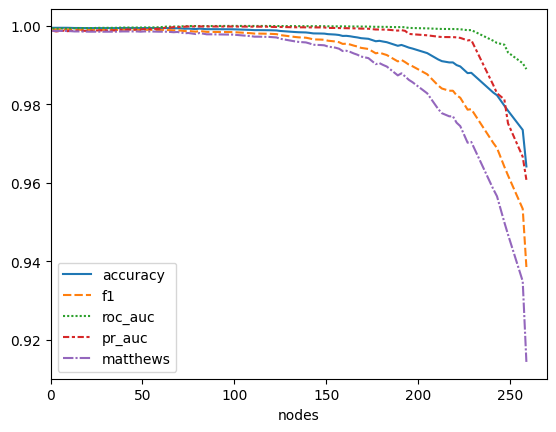

In [62]:
opt1 = GridSearchDecisionTree("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

df = opt1.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.998, 1.0)
display(plt)

In [63]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)
save_model(opt1.model, "decisiontree_building1_tuned")

              precision    recall  f1-score   support

         Off     0.9995    0.9996    0.9995     26732
          On     0.9989    0.9986    0.9988     10343

    accuracy                         0.9993     37075
   macro avg     0.9992    0.9991    0.9992     37075
weighted avg     0.9993    0.9993    0.9993     37075



#### Building 2

All parameters have been previously checked.


<Axes: xlabel='nodes'>

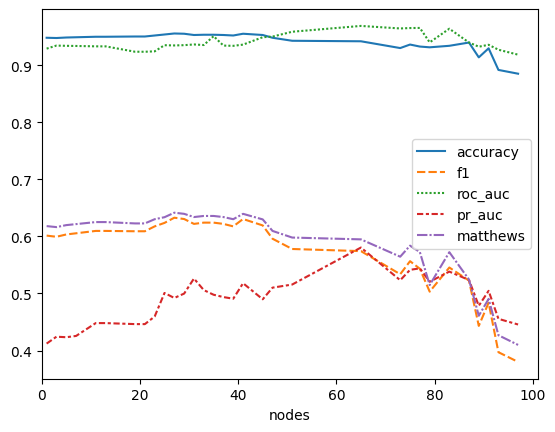

In [64]:
opt2 = GridSearchDecisionTree("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

df = opt2.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.6, 1.0)
display(plt)

In [65]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)
save_model(opt2.model, "decisiontree_building2_tuned")

              precision    recall  f1-score   support

         Off     0.9913    0.9597    0.9752      2135
          On     0.5805    0.8686    0.6959       137

    accuracy                         0.9542      2272
   macro avg     0.7859    0.9142    0.8356      2272
weighted avg     0.9665    0.9542    0.9584      2272



#### Building 3

All parameters have been previously checked.


<Axes: xlabel='nodes'>

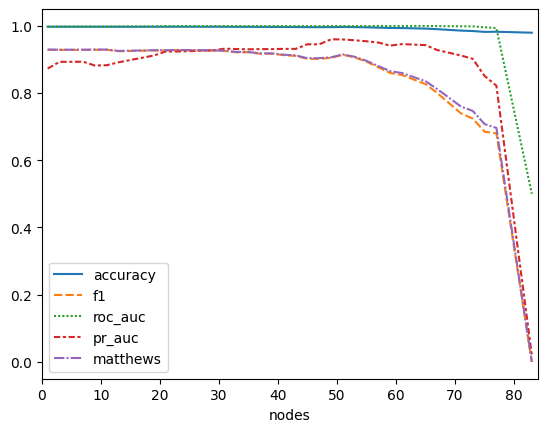

In [66]:
opt3 = GridSearchDecisionTree("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

df = opt3.results
df = pd.DataFrame(df[scores], index=df["nodes"])
plt = sns.lineplot(df)
plt.set_xlim(0, len(df))
#plt.set_ylim(0.92, 1.0)
display(plt)

In [67]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)
save_model(opt3.model, "decisiontree_building3_tuned")

              precision    recall  f1-score   support

         Off     0.9998    0.9960    0.9979     45812
          On     0.8348    0.9904    0.9060       934

    accuracy                         0.9959     46746
   macro avg     0.9173    0.9932    0.9519     46746
weighted avg     0.9965    0.9959    0.9961     46746



### Random Forest

In [68]:
from mlmodel import GridSearchRandomForest
model_name = "Random Forest"
#save_folder = "output/random_forest/analysis"
save_folder = None

#### Building 1

In [69]:
opt1 = GridSearchRandomForest("building1", n_fits=-1)
opt1.fit(x_train1, y_train1, x_val1, y_val1)
if save_folder:
    print(opt1.save_results(save_folder))

opt1.model[-1]

  0%|          | 0/324 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
df = opt1.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
#plt.set_xlim(0, df.index.max())
#plt.set_ylim(0.98, 1.0)
display(plt)

In [ ]:
tuned_metrics["Building 1"][model_name] = calculate_metrics(opt1.model, x_test1, y_test1)
save_model(opt1.model, "randomforest_building1_tuned")

#### Building 2

In [ ]:
opt2 = GridSearchRandomForest("building2", n_fits=-1)
opt2.fit(x_train2, y_train2, x_val2, y_val2)
if save_folder:
    print(opt2.save_results(save_folder))

opt2.model[-1]

In [ ]:
df = opt2.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [ ]:
tuned_metrics["Building 2"][model_name] = calculate_metrics(opt2.model, x_test2, y_test2)
save_model(opt2.model, "randomforest_building2_tuned")

In [ ]:
opt3 = GridSearchRandomForest("building3", n_fits=-1)
opt3.fit(x_train3, y_train3, x_val3, y_val3)
if save_folder:
    print(opt3.save_results(save_folder))

opt3.model[-1]

In [ ]:
df = opt3.results
df = pd.DataFrame(df[scores], index=df["min_samples_split"])
plt = sns.lineplot(df)
display(plt)

In [ ]:
tuned_metrics["Building 3"][model_name] = calculate_metrics(opt3.model, x_test3, y_test3)
save_model(opt3.model, "randomforest_building3_tuned")

## Tuned Model Performance
### Building 1

In [70]:
pd.DataFrame(tuned_metrics["Building 1"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest (default),0.999784,0.999613,0.999464,26730.0,2.0,6.0,10337.0
Hist Gradient Boosting (default),0.999595,0.999275,0.998994,26723.0,9.0,6.0,10337.0
Decision Tree (default),0.999514,0.999130,0.998793,26723.0,9.0,9.0,10334.0
Decision Tree,0.999326,0.998791,0.998324,26721.0,11.0,14.0,10329.0
RBF SVM (default),0.963048,0.933976,0.908329,26015.0,717.0,653.0,9690.0
Linear SVM (default),0.819042,0.676534,0.550924,23350.0,3382.0,3327.0,7016.0
Linear Discriminant Analysis (default),0.818827,0.658949,0.537285,23869.0,2863.0,3854.0,6489.0
Logistic Regression (default),0.779501,0.559370,0.419832,23711.0,3021.0,5154.0,5189.0


### Building 2

In [71]:
pd.DataFrame(tuned_metrics["Building 2"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Random Forest (default),0.975352,0.819355,0.812643,2089.0,46.0,10.0,127.0
Hist Gradient Boosting (default),0.969630,0.783699,0.776680,2078.0,57.0,12.0,125.0
Decision Tree,0.954225,0.695906,0.688203,2049.0,86.0,18.0,119.0
Decision Tree (default),0.946303,0.664835,0.661665,2029.0,106.0,16.0,121.0
RBF SVM (default),0.940141,0.537415,0.506915,2057.0,78.0,58.0,79.0
Linear Discriminant Analysis (default),0.911532,0.385321,0.344273,2008.0,127.0,74.0,63.0
Logistic Regression (default),0.906250,0.375367,0.334380,1995.0,140.0,73.0,64.0
Linear SVM (default),0.920335,0.336996,0.294620,2045.0,90.0,91.0,46.0


### Building 3

In [72]:
pd.DataFrame(tuned_metrics["Building 3"]).T.sort_values("f1", ascending=False)

,Accuracy,f1,Matthews,TN,FP,FN,TP
Hist Gradient Boosting (default),0.996556,0.920415,0.921495,45654.0,158.0,3.0,931.0
Decision Tree,0.995893,0.905975,0.907339,45629.0,183.0,9.0,925.0
Random Forest (default),0.995743,0.903163,0.904929,45619.0,193.0,6.0,928.0
Decision Tree (default),0.994973,0.886309,0.888075,45595.0,217.0,18.0,916.0
Linear Discriminant Analysis (default),0.972297,0.487940,0.492743,44834.0,978.0,317.0,617.0
Linear SVM (default),0.964917,0.447067,0.466624,44443.0,1369.0,271.0,663.0
Logistic Regression (default),0.960553,0.424110,0.450879,44223.0,1589.0,255.0,679.0
RBF SVM (default),0.724490,0.065452,0.066541,33416.0,12396.0,483.0,451.0
